# Sentimen Analysis : Fine-Tuning Bert (Transformer) 

In [1]:
!pip install transformers -U

   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   ------------------------------- -------- 7.9/10.1 MB 40.4 MB/s eta 0:00:01
   ---------------------------------------- 10.1/10.1 MB 28.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ---------------------------------------- 2.4/2.4 MB 33.8 MB/s eta 0:00:00


In [ ]:
import kagglehub
import os
import shutil
path = kagglehub.dataset_download("bittlingmayer/amazonreviews")
print("Chemin de l'archive téléchargée :", path)

# Dossier de destination pour déplacer l'archive
destination_dir = "C:/Users/alexi/aProjets_Code/IA Projet 2/epf-ia-sentiment-analysis/amazonreviews_dataset"
os.makedirs(destination_dir, exist_ok=True)

# Chemin complet de l'archive dans le dossier de destination
# Récupère le nom de l'archive (ex: "archive.zip")
archive_name = os.path.basename(path)
new_archive_path = os.path.join(destination_dir, archive_name)

# Déplacer l'archive vers le dossier de destination
shutil.move(path, new_archive_path)
print(f"Archive déplacée vers : {new_archive_path}")

# Dossier pour extraire l'archive
extract_dir = os.path.join(destination_dir, "amazonreviews")
os.makedirs(extract_dir, exist_ok=True)
print(f"Archive extraite dans : {extract_dir}")

## Data conversion from bz2 to csv

In [2]:
import pandas as pd

import bz2

def decompress_bz2(file_path, output_path):
    with bz2.open(file_path, 'rt', encoding='utf-8') as file:
        with open(output_path, 'w', encoding='utf-8') as out_file:
            out_file.write(file.read())


# Decompress the files
decompress_bz2('./amazonreviews_dataset/7/train.ft.txt.bz2', 'train.ft.txt')

In [3]:
def parse_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            label, text = line.split(' ', 1)
            label = int(label.replace('__label__', ''))
            data.append((label, text.strip()))
    return pd.DataFrame(data, columns=['label', 'text'])


In [4]:
train = parse_data('train.ft.txt')

train

,label,text
0,2,Stuning even for the non-gamer: This sound tra...
1,2,The best soundtrack ever to anything.: I'm rea...
2,2,Amazing!: This soundtrack is my favorite music...
3,2,Excellent Soundtrack: I truly like this soundt...
4,2,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
3599995,1,Don't do it!!: The high chair looks great when...
3599996,1,"Looks nice, low functionality: I have used thi..."
3599997,1,"compact, but hard to clean: We have a small ho..."
3599998,1,what is it saying?: not sure what this book is...


In [5]:
df = train.copy()
df.label = df.label.map({2:0, 1:1})  # 1 are negatives (targeted class)
df

,label,text
0,0,Stuning even for the non-gamer: This sound tra...
1,0,The best soundtrack ever to anything.: I'm rea...
2,0,Amazing!: This soundtrack is my favorite music...
3,0,Excellent Soundtrack: I truly like this soundt...
4,0,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
3599995,1,Don't do it!!: The high chair looks great when...
3599996,1,"Looks nice, low functionality: I have used thi..."
3599997,1,"compact, but hard to clean: We have a small ho..."
3599998,1,what is it saying?: not sure what this book is...


In [21]:
# We're going to use only 10000 records from the data for faster training
df = df[0:10000]
df

,label,text
0,0,Stuning even for the non-gamer: This sound tra...
1,0,The best soundtrack ever to anything.: I'm rea...
2,0,Amazing!: This soundtrack is my favorite music...
3,0,Excellent Soundtrack: I truly like this soundt...
4,0,"Remember, Pull Your Jaw Off The Floor After He..."
...,...,...
9995,0,A revelation of life in small town America in ...
9996,0,Great biography of a very interesting journali...
9997,1,Interesting Subject; Poor Presentation: You'd ...
9998,1,Don't buy: The box looked used and it is obvio...


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   10000 non-null  int64 
 1   text    10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


label
1    5097
0    4903
Name: count, dtype: int64


<Axes: xlabel='label'>

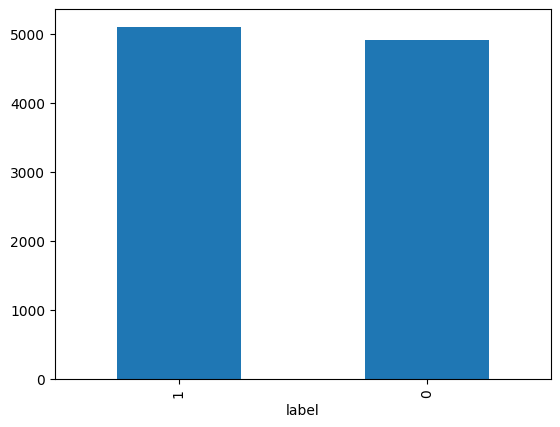

In [23]:
# Data is balanced
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar')

## Model Training

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)

In [26]:
X = list(df["text"])
y = list(df["label"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

In [27]:
# Converting X and y into Pytorch Dataset (as transformers accept data in that format)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

# This method is used to retrieve a single sample from the dataset.
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

* encodings: A dictionary where each key corresponds to an input feature (e.g., "input_ids", "attention_mask", etc.). Each value is a list or array of encoded inputs.

In [28]:
train_dataset = Dataset(X_train_tokenized, y_train)
test_dataset = Dataset(X_test_tokenized, y_test)

In [29]:
train_dataset[3]

{'input_ids': tensor([  101,  8632,  1997, 18015,  1011,  3828,  2115,  2769,   999,  1024,
          1996,  2034,  2028,  1045,  2363,  1996, 17371,  4003, 10453,  5843,
          2106,  2025,  2147,  1012,  1996,  2117,  2028,  6719,  2165,  1019,
          2000,  2184,  2781,  2000,  9573,  2039,  1012,  1045,  2513,  2009,
          2153,  2000, 19575,  8894,  1006,  9733, 14939,  1007,  1998,  2027,
          2056,  2027,  2052,  2025,  3715,  2033,  1996,  2321,  1003,  2717,
          7432,  2075,  7408,  2029,  2027,  2106,  2151, 14406,  1012,  2035,
          1999,  2035,  1010,  1045,  2876,  1005,  1056,  2219,  2178,  5472,
         20573, 23378,  2130,  2065,  2027,  2052,  2507,  2033,  2028,  2005,
          2489,   999,  1045,  1005,  1049,  2041,  1002,  2184,  1012,  4002,
          2005,  2048,  2709, 24636,  1998,  2178,  1002,  2184,  1012,  4002,
          2717,  7432,  2075,  7408,  1012,  2498,  2000,  2717,  7432,  2012,
         19575,  8894,  1010,  4604,  1

In [30]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [31]:
# Define Trainer

args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=8

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [32]:
trainer.train()

Step,Training Loss
500,0.318500
1000,0.254300


TrainOutput(global_step=1000, training_loss=0.2863903961181641, metrics={'train_runtime': 275.2322, 'train_samples_per_second': 29.066, 'train_steps_per_second': 3.633, 'total_flos': 1188110859360000.0, 'train_loss': 0.2863903961181641, 'epoch': 1.0})

## Performance Metrics

In [33]:
trainer.evaluate()

{'eval_loss': 0.22056439518928528,
 'eval_accuracy': 0.9455,
 'eval_precision': 0.9496047430830039,
 'eval_recall': 0.943081452404318,
 'eval_f1': 0.9463318562284588,
 'eval_runtime': 25.7721,
 'eval_samples_per_second': 77.603,
 'eval_steps_per_second': 9.7,
 'epoch': 1.0}

## Testing Model

In [35]:
def classify_text(text, model, tokenizer):
    # Tokenize the input text and move it to the GPU
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to('cuda')
    
    # Get model outputs
    outputs = model(**inputs)
    
    # Apply softmax to the logits to get probabilities
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    # Move the predictions back to CPU and convert to numpy array
    predictions = predictions.cpu().detach().numpy()
    
    # Print the predictions
    print(predictions)
    
    # Check the first index and print the corresponding label
    if predictions[0][0] > 0.5:
        print("Positive")
    else:
        print("Negative")
    
    return predictions

predictions = classify_text("The mobile is awesome", model, tokenizer)

[[0.99762744 0.00237252]]
Positive


In [37]:
predictions = classify_text("The mobile is bad", model, tokenizer)

[[0.00194693 0.9980531 ]]
Negative


In [39]:
predictions = classify_text("""After purchasing such an expensive item we do not expect such damaged item box. 
The box was damaged in various places and had tape applied on the front. I don't know whether the damage was
due to the box falling or not. I am also confused whether the box and PS5 might have suffered any damage due to the fall. 
I am not satisfied. You have to give proper box packing without any damage.""", model, tokenizer)

[[0.00431075 0.9956892 ]]
Negative
